In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
%pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
%pip install skforecast
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
data = pd.read_csv("C:/Users/lrodr/OneDrive/Documentos/master_ucm/trabajos/7/data.csv")

In [3]:
data.head()

,Year,Anomaly
0,1874,-0.23
1,1875,-0.22
2,1876,-0.24
3,1877,0.12
4,1878,0.12


In [4]:
# Convertir el índice a datetime si no lo está
data["Year"] = pd.to_datetime(data["Year"], format="%Y")

In [5]:
data.index = data['Year']
del data['Year']
print(data.head())

            Anomaly
Year               
1874-01-01    -0.23
1875-01-01    -0.22
1876-01-01    -0.24
1877-01-01     0.12
1878-01-01     0.12


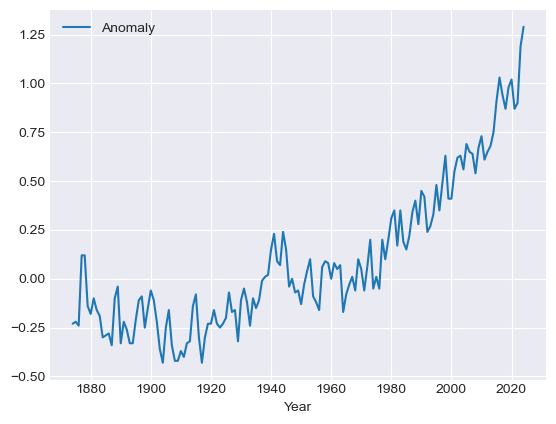

In [6]:
sns.lineplot(data)
plt.show()

Text(0.5, 1.0, 'Serie diferenciada de orden 1')

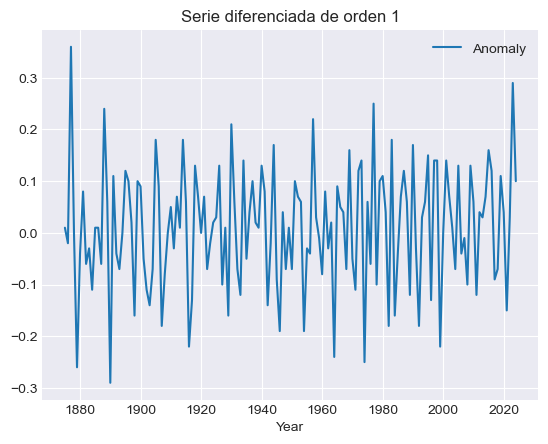

In [7]:
sns.lineplot(data.diff())
plt.title("Serie diferenciada de orden 1")

In [8]:
data_diff_1 = data.diff(1).dropna()
print('Test estacionariedad serie original')
print(f'ADF Statistic: {adfuller(data)[0]}, p-value: {adfuller(data)[1]}')
print(f'KPSS Statistic: {kpss(data)[0]}, p-value: {kpss(data)[1]}')
print('\nTest estacionariedad serie diferenciada de orden 1')
print(f'ADF Statistic: {adfuller(data_diff_1)[0]}, p-value: {adfuller(data_diff_1)[1]}')
print(f'KPSS Statistic: {kpss(data_diff_1)[0]}, p-value: {kpss(data_diff_1)[1]}')

Test estacionariedad serie original
ADF Statistic: 1.9020335186272215, p-value: 0.9985312835501976
KPSS Statistic: 1.484156626569767, p-value: 0.01

Test estacionariedad serie diferenciada de orden 1
ADF Statistic: -7.466760512058273, p-value: 5.1800024309746794e-11
KPSS Statistic: 0.4038286007299803, p-value: 0.07550491347845678


C:\Users\lrodr\AppData\Local\Temp\ipykernel_16648\877184301.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f'KPSS Statistic: {kpss(data)[0]}, p-value: {kpss(data)[1]}')
C:\Users\lrodr\AppData\Local\Temp\ipykernel_16648\877184301.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f'KPSS Statistic: {kpss(data)[0]}, p-value: {kpss(data)[1]}')


<Axes: title={'center': 'Diferenciación orden 1'}, xlabel='Year'>

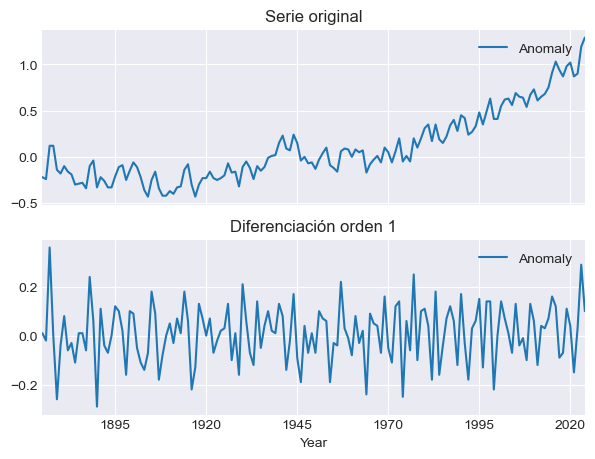

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Serie original')
data_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')

Text(0.5, 1.0, 'Autocorrelación parcial serie diferenciada de orden 1')

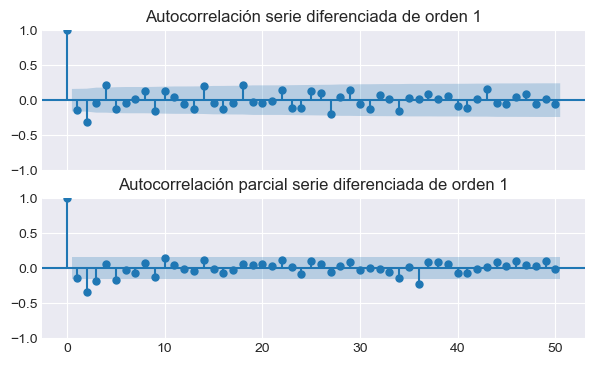

In [10]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data_diff_1, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie diferenciada de orden 1')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación parcial serie diferenciada de orden 1')

In [11]:
data_TR = data.iloc[:-10]
data_TST = data.iloc[-10:]

In [12]:
# Modelo ARIMA con statsmodels.arima
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = ARIMA(order = (1, 1, 0))
modelo_res = modelo.fit(data_TR)
warnings.filterwarnings("default")
modelo_res.summary()

c:\Users\lrodr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\lrodr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 106.459
Date:                Thu, 20 Feb 2025   AIC                           -206.917
Time:                        17:27:24   BIC                           -198.092
Sample:                    01-01-1874   HQIC                          -203.331
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0082      0.010      0.852      0.394      -0.011       0.027
ar.L1         -0.1828      0.101     -1.818      0.069      -0.380       0.014
sigma2         0.0128      0.002      7.959      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.44   Prob(JB):                         0.77
Heteroskedasticity (H):               0.80   Skew:                            -0.14
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Predicción
# ==============================================================================
predicciones_pmdarima = modelo_res.predict(n_periods=10)
display(predicciones_pmdarima.head(4)) 


2015-01-01    0.745391
2016-01-01    0.754422
2017-01-01    0.760959
2018-01-01    0.767952
Freq: YS-JAN, dtype: float64

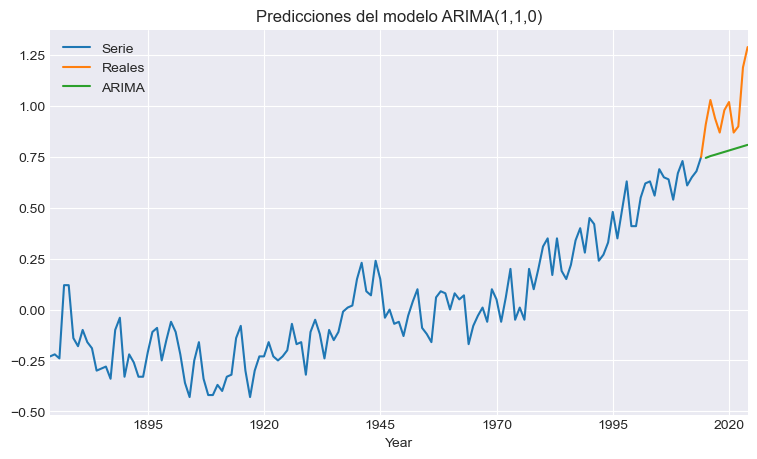

In [14]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
data_TR.plot(ax=ax, label='Serie')
data.iloc[-11:].plot(ax=ax, label='Reales')
predicciones_pmdarima.plot(ax=ax, label='ARIMA')
ax.set_title('Predicciones del modelo ARIMA(1,1,0)')
ax.legend(['Serie', 'Reales', 'ARIMA']) 

In [15]:
# Mean Squared Error (MSE)
mse = mean_squared_error(data_TST, predicciones_pmdarima)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(data_TST, predicciones_pmdarima)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.06428515601975546
Root Mean Squared Error (RMSE): 0.2535451755008473
Mean Absolute Error (MAE): 0.2218251288498833


In [16]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = data_TR,
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = False,
            test              = 'adf',
            d                 = None, # El algoritmo determina 'd'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-204.134, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-206.917, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-218.405, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-205.616, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-215.559, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-229.997, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-228.047, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-228.100, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-233.637, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-229.294, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-227.567, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-231.658, Time=0.17 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 1.700 seconds


In [17]:
# Modelo ARIMA con statsmodels.arima
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo_final = ARIMA(order = (1,1,3))
modelo_final_res = modelo_final.fit(data_TR)
warnings.filterwarnings("default")
modelo_final_res.summary()

c:\Users\lrodr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\lrodr\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 122.818
Date:                Thu, 20 Feb 2025   AIC                           -233.637
Time:                        17:27:26   BIC                           -215.987
Sample:                    01-01-1874   HQIC                          -226.464
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.006      2.077      0.038       0.001       0.024
ar.L1         -0.9496      0.052    -18.292      0.000      -1.051      -0.848
ma.L1          0.6745      0.093      7.278      0.000       0.493       0.856
ma.L2         -0.6147      0.089     -6.910      0.000      -0.789      -0.440
ma.L3         -0.4115      0.081     -5.076      0.000      -0.570      -0.253
sigma2         0.0101      0.001      7.822      0.000       0.008       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.74   Prob(JB):                         0.62
Heteroskedasticity (H):               0.88   Skew:                             0.18
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
predicciones_pmdarima_fin = modelo_final_res.predict(n_periods=10)

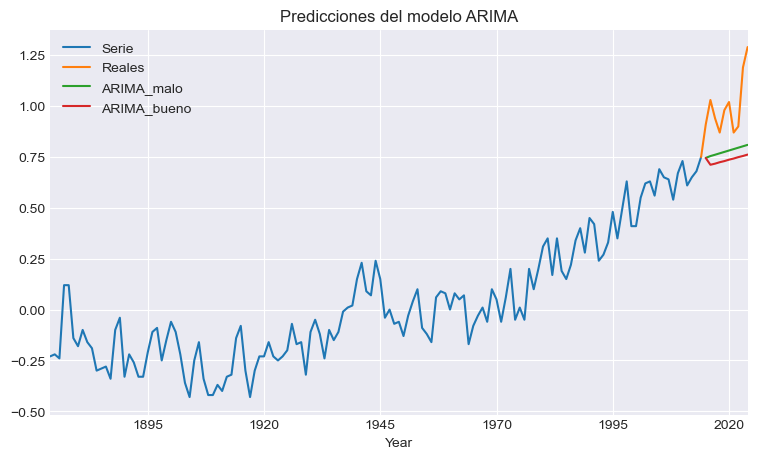

In [19]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
data_TR.plot(ax=ax, label='Serie')
data.iloc[-11:].plot(ax=ax, label='Reales')
predicciones_pmdarima.plot(ax=ax, label='ARIMA_malo')
predicciones_pmdarima_fin.plot(ax=ax, label='ARIMA_bueno')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend(['Serie', 'Reales', 'ARIMA_malo', 'ARIMA_bueno'])

In [20]:
# Mean Squared Error (MSE)
mse = mean_squared_error(data_TST, predicciones_pmdarima_fin)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(data_TST, predicciones_pmdarima_fin)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.08499075650353012
Root Mean Squared Error (RMSE): 0.29153174184560093
Mean Absolute Error (MAE): 0.26277130040734215


In [21]:
pred, conf_int = modelo_final_res.predict(n_periods=10, return_conf_int=True)
pred_index = pd.date_range(start=data_TR.index[-1] + pd.DateOffset(years=1), periods=10, freq='A')  # Ajusta la frecuencia según la serie
pred_series = pd.Series(pred, index=pred_index)
conf_lower = conf_int[:, 0]  # Límite inferior
conf_upper = conf_int[:, 1]  # Límite superior

C:\Users\lrodr\AppData\Local\Temp\ipykernel_16648\2579068137.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  pred_index = pd.date_range(start=data_TR.index[-1] + pd.DateOffset(years=1), periods=10, freq='A')  # Ajusta la frecuencia según la serie


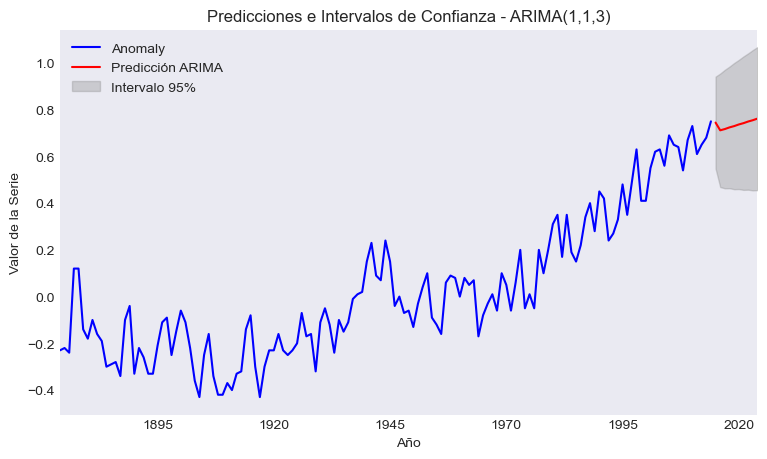

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
data_TR.plot(ax=ax, label='Serie Histórica', color='blue')
pred.plot(ax=ax, label='Predicción ARIMA', color='red')
ax.fill_between(pred_index, conf_lower, conf_upper, color='gray', alpha=0.3, label='Intervalo 95%')
ax.set_title('Predicciones e Intervalos de Confianza - ARIMA(1,1,3)')
ax.legend()
plt.xlabel('Año')
plt.ylabel('Valor de la Serie')
plt.grid()
plt.show()